In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import plotly.express as px

### load the data

In [97]:
final_data = pd.read_csv('final_data.csv')

In [98]:
final_data.head()

,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month,day_of_week,Reason for Absence_1,Reason for Absence_2,Reason for Absence_3,Reason for Absence_4
0,289,36,33,239.554,30,0,2,1,4,7,1,0,0,0,1
1,118,13,50,239.554,31,0,1,0,0,7,1,0,0,0,0
2,179,51,38,239.554,31,0,0,0,2,7,2,0,0,0,1
3,279,5,39,239.554,24,0,2,0,4,7,3,1,0,0,0
4,289,36,33,239.554,30,0,2,1,2,7,3,0,0,0,1


### create the target

In [99]:
final_data['Excessive Absenteeism'] = final_data['Absenteeism Time in Hours'].apply(lambda x: 1 if x>final_data['Absenteeism Time in Hours'].median() else 0)

In [100]:
#another way to do it:
# final_data['Excessive Absenteeism'] = np.where(final_data['Absenteeism Time in Hours']>final_data['Absenteeism Time in Hours'].median(),1,0)

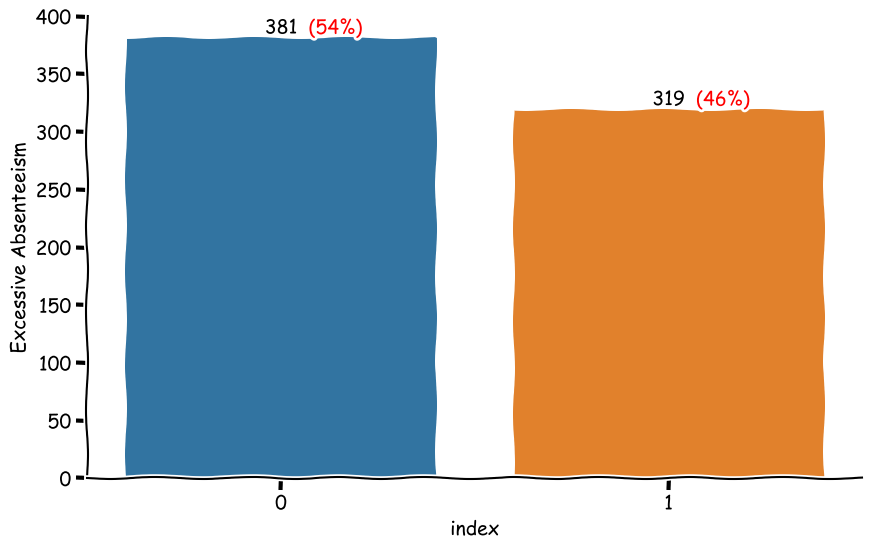

In [101]:
with plt.xkcd():
    sns.barplot(data=final_data['Excessive Absenteeism'].value_counts().reset_index(),y='Excessive Absenteeism', x='index',errorbar=None )
    ax = plt.gca()
    for i in ax.containers:
        plt.bar_label(i)
    for p in ax.patches:
        pct ='(%1.f%%)' % (100*p.get_height()/final_data.shape[0])
        plt.annotate(pct, (p.get_x()+p.get_width()/1.7, p.get_height()+4), color='r')
    fig = plt.gcf()
    fig.set_size_inches(10,6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False);

In [102]:
final_data.drop(['Absenteeism Time in Hours', 'Month', 'Age'], axis=1, inplace=True)

In [103]:
final_data.head()

,Transportation Expense,Distance to Work,Daily Work Load Average,Body Mass Index,Education,Children,Pets,day_of_week,Reason for Absence_1,Reason for Absence_2,Reason for Absence_3,Reason for Absence_4,Excessive Absenteeism
0,289,36,239.554,30,0,2,1,1,0,0,0,1,1
1,118,13,239.554,31,0,1,0,1,0,0,0,0,0
2,179,51,239.554,31,0,0,0,2,0,0,0,1,0
3,279,5,239.554,24,0,2,0,3,1,0,0,0,1
4,289,36,239.554,30,0,2,1,3,0,0,0,1,0


In [104]:
y = final_data['Excessive Absenteeism']

In [105]:
X = final_data.drop('Excessive Absenteeism', axis=1).copy()

In [204]:
X.columns

Index(['Transportation Expense', 'Distance to Work', 'Daily Work Load Average',
       'Body Mass Index', 'Education', 'Children', 'Pets', 'day_of_week',
       'Reason for Absence_1', 'Reason for Absence_2', 'Reason for Absence_3',
       'Reason for Absence_4'],
      dtype='object')

### split the input and fit the dataset with our pipeline

In [106]:
class CustomScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
        self.mean_ = None
        self.var_ = None
        
    def fit(self, X, y = None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        init_col_order = X.columns
        x_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        x_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([x_scaled, x_not_scaled], axis=1)[init_col_order]

In [107]:
not_dummies = ['Transportation Expense', 'Distance to Work',
       'Daily Work Load Average', 'Body Mass Index', 'Children',
       'Pets', 'day_of_week']

In [108]:
pipe = Pipeline([('scaler', CustomScaler(not_dummies)),('clf', LogisticRegression())])

In [109]:
pipe.fit(X.iloc[:500,:],y[:500])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



Pipeline(steps=[('scaler',
                 CustomScaler(columns=['Transportation Expense',
                                       'Distance to Work',
                                       'Daily Work Load Average',
                                       'Body Mass Index', 'Children', 'Pets',
                                       'day_of_week'])),
                ('clf', LogisticRegression())])

In [110]:
pipe.score(X.iloc[:500,:],y[:500]) # the accuracy score

0.764

In [111]:
prediction = pipe.predict(X.iloc[:500,:])

In [112]:
np.sum(y[:500]==prediction)

382

In [113]:
X.iloc[:500,:].shape[0]

500

In [114]:
np.sum(y[:500]==prediction)/X.iloc[:500,:].shape[0] # this is how the accuracy calculated

0.764

### the intercept and coefficients 

In [115]:
pipe.steps[1][1].intercept_

array([-1.54900305])

In [116]:
pipe.steps[1][1].coef_[0]

array([ 0.58037796,  0.12266046, -0.09551836,  0.11733009,  0.36049222,
        0.34201404, -0.15375327, -0.19692465,  2.88053785,  1.20422314,
        3.05530258,  0.93501181])

In [117]:
X.columns.values

array(['Transportation Expense', 'Distance to Work',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'day_of_week', 'Reason for Absence_1',
       'Reason for Absence_2', 'Reason for Absence_3',
       'Reason for Absence_4'], dtype=object)

In [118]:
summary = pd.DataFrame({'feature name':X.columns.values, 'coef':pipe.steps[1][1].coef_[0]})

In [119]:
summary.index = summary.index + 1
summary.loc[0] = ['intercept', pipe.steps[1][1].intercept_[0]]
summary = summary.sort_index()
summary['odd_ratio'] = np.exp(summary['coef'])
summary

,feature name,coef,odd_ratio
0,intercept,-1.549003,0.212460
1,Transportation Expense,0.580378,1.786714
2,Distance to Work,0.122660,1.130501
3,Daily Work Load Average,-0.095518,0.908902
4,Body Mass Index,0.117330,1.124491
5,Education,0.360492,1.434035
6,Children,0.342014,1.407780
7,Pets,-0.153753,0.857484
8,day_of_week,-0.196925,0.821253
9,Reason for Absence_1,2.880538,17.823857


### evaluate the model

In [158]:
y_predict = pipe.predict(X.iloc[:700,:])

In [159]:
ytest_pred = y_predict[500:]

In [193]:
print(classification_report(y[500:], ytest_pred))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       131
           1       0.59      0.80      0.68        69

    accuracy                           0.74       200
   macro avg       0.73      0.75      0.73       200
weighted avg       0.77      0.74      0.75       200



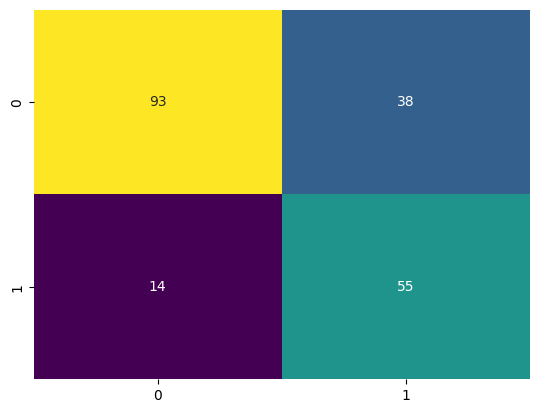

In [200]:
sns.heatmap(confusion_matrix(y[500:], ytest_pred), annot=True, cbar=False, cmap='viridis');

### save the model

In [201]:
import pickle

In [202]:
with open('final_model', 'wb') as file:
    pickle.dump(pipe, file)